# Calibration for $Q$

### Initialization

In [2]:
using DrWatson
@quickactivate "momdist"

In [3]:
ENV["LD_LIBRARY_PATH"] = ""
ENV["JULIA_GR_PROVIDER"] = "GR"

using Plots, StatsPlots

In [4]:
using Random, Distributions, Parameters, Pipe, ProgressMeter, JLD2
using Distances, LinearAlgebra, Statistics, LazySets, LambertW, Hyperopt
using Ripserer, PersistenceDiagrams, PersistenceDiagramsBase

In [5]:
import RobustTDA as rtda

In [6]:
ProgressMeter.ijulia_behavior(:clear)
plot_par = rtda.plot_params(alpha=0.3);

reps = 30

30

## Lepski's method

In [7]:
function one_lepski_iter(mmin=50, mmax=150; params)

    # Generate Random Data
    begin
        n = 500
        m = rand([mmin:1:mmax]..., 1)[1]

        # Signal
        signal = 2.5 .* rtda.randCircle(n, sigma=0.05)

        # Noise
        l = 1.5
        win = (-l, l, -l, l)
        noise = rtda.randMClust(m, window=win, λ1=2, λ2=10, r=0.05)

        # Concatenate
        X = [signal; noise] |> rtda._ArrayOfVectors_to_ArrayOfTuples
        Xn = X |> rtda._ArrayOfTuples_to_ArrayOfVectors
    end

    m̂ = rtda.lepski(Xn=Xn, params = params)
    return (m̂ - m) / m
end

one_lepski_iter (generic function with 3 methods)

In [8]:
# Initialize the Hyperparameters

θ = rtda.lepski_params(
    a=0.2,
    b=1,
    mmin=50,
    mmax=200,
    pi=1.1,
    δ=0.01
)

Lep = Any[]

Random.seed!(2022)

prog = Progress(reps)
for i in 1:reps
    println("\n i=$i")
    Lep = vcat(Lep, one_lepski_iter(params=θ));
    next!(prog)
end

# jldsave(datadir("Lep.jld2"); Lep)

Progress:  84%|██████████████████████████████████▎      |  ETA: 0:00:06
Progress: 100%|█████████████████████████████████████████| Time: 0:27:49


### Heuristic Procedure

In [9]:
function heuristic(Xn; Q, p=1)
    D1 = @pipe rtda.momdist(Xn, floor(Int, Q)) |> rtda.fit(Xn, _) |> rtda.wrips(Xn, w=_, p=p)
    D2 = @pipe rtda.momdist(Xn, floor(Int, Q)) |> rtda.fit(Xn, _) |> rtda.wrips(Xn, w=_, p=p)
    return Bottleneck()(D1, D2)
end

heuristic (generic function with 1 method)

In [10]:
function one_iter(mmin=50, step=5, mmax=150; method=heuristic, loops=10)

    # Generate Random Data
    begin
        n = 500
        m = rand([mmin:1:mmax]..., 1)[1]

        # Signal
        signal = 2.5 .* rtda.randCircle(n, sigma=0.05)

        # Noise
        l = 1.5
        win = (-l, l, -l, l)
        noise = rtda.randMClust(m, window=win, λ1=2, λ2=10, r=0.05)

        # Concatenate
        X = [signal; noise] |> rtda._ArrayOfVectors_to_ArrayOfTuples
        Xn = X |> rtda._ArrayOfTuples_to_ArrayOfVectors
    end

    Opt = @hyperopt for i = loops,
        sampler = RandomSampler(),
        Q = (2*mmin+1):step:(2*mmax+1),
        b = [true, false]
        method(Xn, Q=Q, p=1)
    end

    return (round(Int, 0.5 * (Opt.minimizer[1] - 1)) - m) / m
end

one_iter (generic function with 4 methods)

In [11]:
Heu = Any[]

Random.seed!(2022)
for i in 1:reps
    # println("\n i=$i")
    Heu = vcat(Heu, one_iter(loops=50))
end


# jldsave(datadir("Heu.jld2"); Heu)

Hyperoptimizing 100%|████████████████████████████████████| Time: 0:01:44
Hyperoptimizing 100%|████████████████████████████████████| Time: 0:02:01
Hyperoptimizing 100%|████████████████████████████████████| Time: 0:02:06
Hyperoptimizing 100%|████████████████████████████████████| Time: 0:01:23
Hyperoptimizing 100%|████████████████████████████████████| Time: 0:01:34
Hyperoptimizing 100%|████████████████████████████████████| Time: 0:01:52
Hyperoptimizing 100%|████████████████████████████████████| Time: 0:01:37
Hyperoptimizing 100%|████████████████████████████████████| Time: 0:01:39
Hyperoptimizing 100%|████████████████████████████████████| Time: 0:01:53
Hyperoptimizing 100%|████████████████████████████████████| Time: 0:01:37
Hyperoptimizing 100%|████████████████████████████████████| Time: 0:01:28
Hyperoptimizing 100%|████████████████████████████████████| Time: 0:02:42
Hyperoptimizing 100%|████████████████████████████████████| Time: 0:02:02
Hyperoptimizing 100%|██████████████████████████████

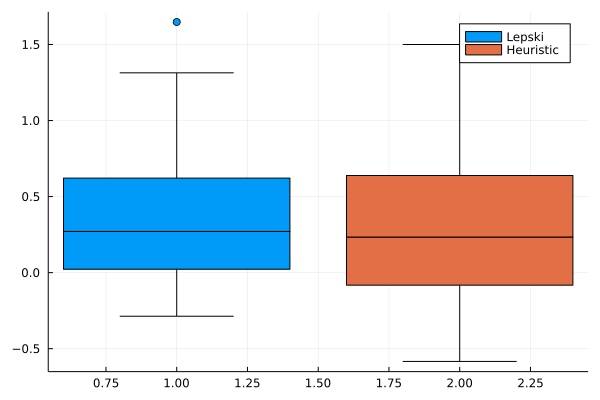

In [13]:
plt = boxplot(Lep, label = "Lepski", legend = :topright)
boxplot(plt, Heu,  label = "Heuristic")